# Prophet test

*Anders Poirel 23-03-2020*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_validate,
                                    TimeSeriesSplit)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from fbprophet import Prophet

## Pre-processing

I take some time to prototype a pre-processing function that we can us in the future. We keep `week_start_date` and drop other time-related features as this the date format `fbprophet` wants

In [4]:
def data_preprocessing(path):
    features = pd.read_csv(path)
    features = features.drop(['year', 'weekofyear'],
                            axis = 1)
    features = features.drop(['reanalysis_sat_precip_amt_mm',
                              'reanalysis_tdtr_k'],
                            axis = 1)
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [5]:
DATA_PATH = '../data/raw'

In [23]:
train_sj, train_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_test.csv'))

In [48]:
train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))
train_sj['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']
train_iq['y'] = train_labels[train_labels['city'] == 'iq']['total_cases']

### San Juan model

In [8]:
model_sj = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False
)
regressors = train_sj.columns.values[1:19]
for name in regressors:
    model_sj.add_regressor(name)

In [29]:
train_sj.head()

,ds,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,14.012857,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,15.372857,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,16.848571,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,16.672857,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,17.210000,28.942857,9.371429,35.0,23.9,5.8


Normally I'd use a `Pipeline` for the full model, but I haven't figured out how to make a `Prophet` model play nice with the rest yet

In [35]:
numeric_features = train_sj.columns[1:]
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scale', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers =  [('num', numeric_transformer, numeric_features)]
)

In [43]:
train_sj.loc[:, 'ndvi_ne':] = preprocessor.fit_transform(train_sj)

In [50]:
model_sj.fit(train_sj)

In [57]:
test_sj.loc[:, 'ndvi_ne':] = preprocessor.transform(test_sj)

In [63]:
forecast = model_sj.predict(train_sj)

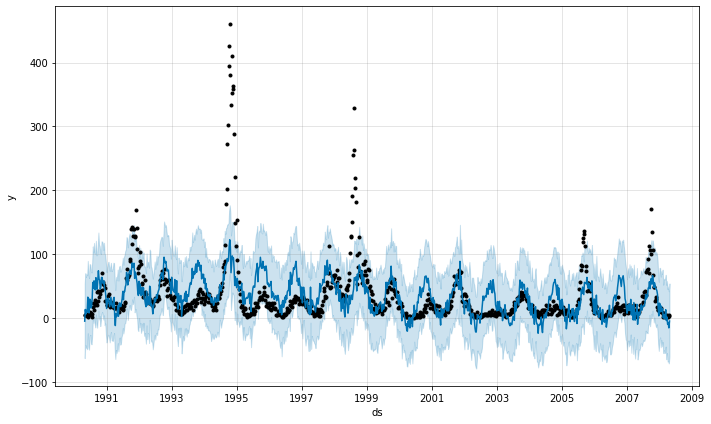

In [64]:
fig = model_sj.plot(forecast)

The model seems to be capturing the main components  of seasonality, but missing the large peaks in cases